In [1]:
import sys
import os
sys.path.append(os.path.abspath('../../'))

from rcgp.morcgp import MOGPRegressor, MORCGPRegressor, MOGPRegressor_NC, MORCGPRegressor_NC, MORCGPRegressor_NC_fixed_weights, MORCGPRegressor_fixed_weights
from rcgp.kernels import ConstantMean, RBFKernel, SineMean
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,         
    "font.family": "serif",       
    "text.latex.preamble": r"\usepackage{amsmath}",
    'font.size': 24,         
    'axes.labelsize': 24,    
    'xtick.labelsize': 24,   
    'ytick.labelsize': 24,  
    'legend.fontsize': 20,
    'lines.linewidth': 4,    
    'lines.markersize': 5   
})

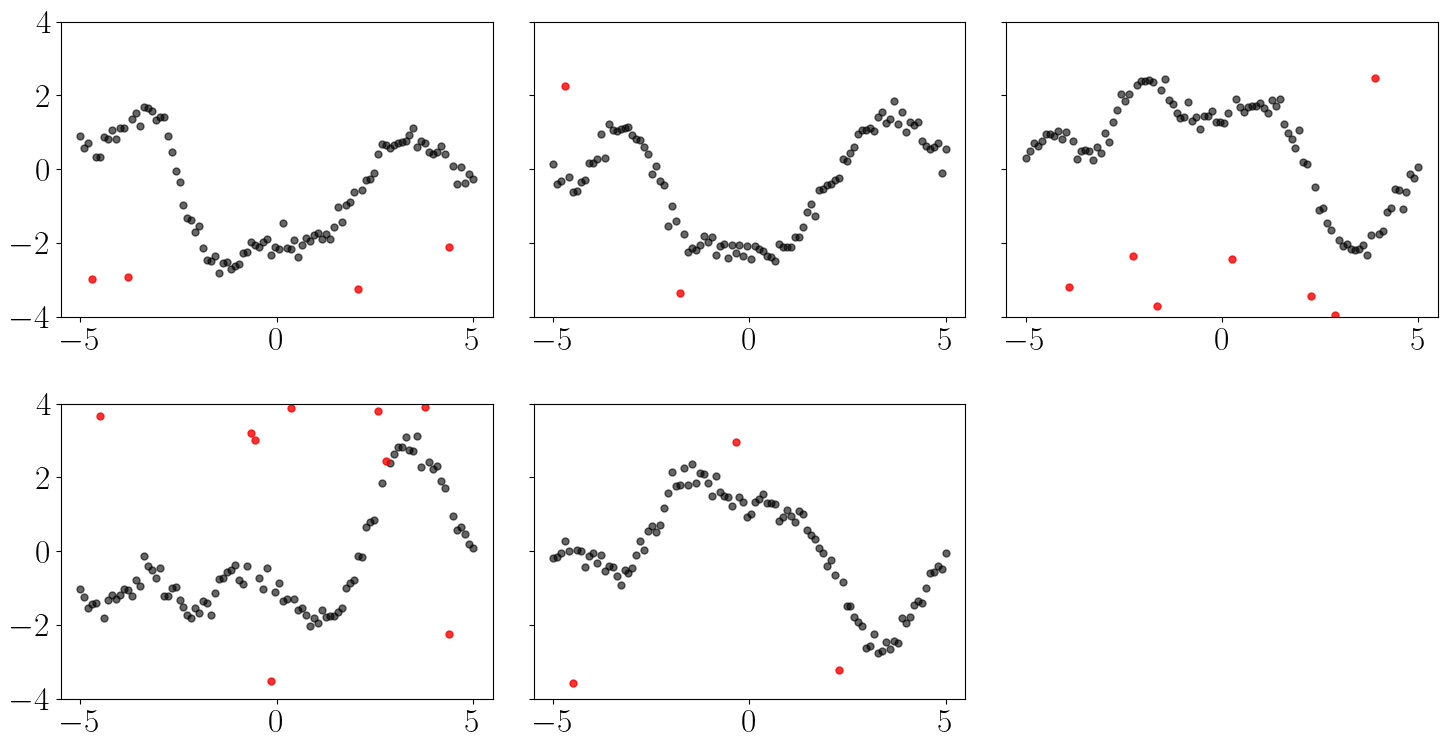

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import cholesky

np.random.seed(42)
N = 100
D = 5  # changed to 5 outputs

x_train = np.linspace(-5, 5, N).reshape(-1, 1)

def rbf_kernel(x1, x2, lengthscale=1.0, variance=1.0):
    sqdist = np.sum(x1**2, 1).reshape(-1,1) + np.sum(x2**2,1) - 2*np.dot(x1, x2.T)
    return variance * np.exp(-0.5 / lengthscale**2 * sqdist)

# Define a 5x5 coregionalization matrix B (symmetric and PSD)
B = np.array([
    [1.0,  0.9,  -0.7,  0.5,  -0.6],
    [0.9,  1.0,  -0.8,  0.6,  -0.7],
    [-0.7, -0.8,  1.0, -0.9,   0.8],
    [0.5,  0.6,  -0.9,  1.0,  -0.85],
    [-0.6, -0.7,  0.8, -0.85,  1.0]
])

A = np.linalg.cholesky(B)

Kx = rbf_kernel(x_train, x_train, lengthscale=1.0, variance=2.0)
K = np.kron(B, Kx)

# Add a small jitter for numerical stability
L = cholesky(K + 1e-6*np.eye(D*N), lower=True)

f_samples = L @ np.random.randn(D*N)
F_train = f_samples.reshape(D, N).T
Y_train = F_train + np.random.normal(0, 0.2, F_train.shape)  # Adding noise

# Add 5% outliers uniformly distributed in [-4, -2] ∪ [2, 4]
num_outliers = int(0.05 * N * D)
indices = np.unravel_index(np.random.choice(N * D, num_outliers, replace=False), (N, D))
uniform_outliers = np.random.uniform(0, 1, num_outliers)
outlier_values = np.where(
    uniform_outliers < 0.5,
    np.random.uniform(-4, -2, num_outliers),
    np.random.uniform(2, 4, num_outliers)
)
Y_train[indices] = outlier_values

# Plotting in 2 rows and 3 columns
fig, axs = plt.subplots(2, 3, figsize=(15, 8))

# Flatten the indices for convenient comparison
outlier_mask = np.zeros((N, D), dtype=bool)
outlier_mask[indices] = True

for i in range(D):
    ax = axs[i // 3, i % 3]
    
    # Separate inliers and outliers
    x_all = x_train.flatten()
    y_all = Y_train[:, i]
    is_outlier = outlier_mask[:, i]

    ax.plot(x_all[~is_outlier], y_all[~is_outlier], 'o', color='black', alpha=0.6, label=f'Output {i+1} - inliers')
    ax.plot(x_all[is_outlier], y_all[is_outlier], 'o', color='red', alpha=0.8, label='Outliers')

    ax.set_ylim([-4, 4])
    if i % 3 != 0:
        ax.set_yticklabels([])

# Hide the unused 6th subplot
axs[1, 2].axis('off')

plt.tight_layout()
plt.show()

Optimized length_scale: 1.1385, noise: 0.637786
Optimized A: [[ 1.32122247  0.2353167   0.0271095  -0.02956362 -0.01565144]
 [ 1.24855155  0.42284115 -0.11697063  0.01261236 -0.13693363]
 [-0.89751178 -0.40600473  0.74147627 -0.33825706  0.03378604]
 [ 0.67342355  0.58180311 -1.14345097  0.41515142  0.0195231 ]
 [-0.99107708 -0.45874068  0.34116801 -0.34978406  0.44467329]]
Optimized B: 
[[ 1.80285665  1.74771527 -1.25178007  0.98307299 -1.40475265]
 [ 1.74771527  1.77026763 -1.38788885  1.22312717 -1.53659423]
 [-1.25178007 -1.38788885  1.63571364 -1.82823043  1.46206291]
 [ 0.98307299  1.22312717 -1.82823043  2.2722061  -1.46095224]
 [-1.40475265 -1.53659423  1.46206291 -1.46095224  1.62915563]]


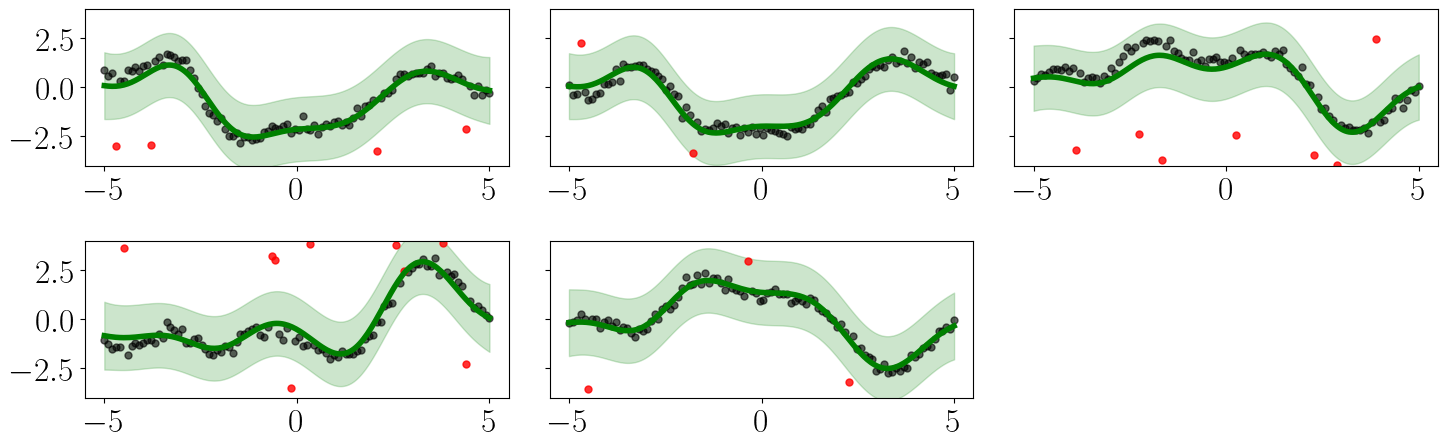

In [3]:
# mogp = MOGPRegressor(mean=0, length_scale=1.0, noise = np.array([0.2] * D), A = 2*A)
mogp = MOGPRegressor_NC(mean=0, length_scale=1.0, noise = 0.2, A = 2*A)
mogp.fit(x_train, Y_train)

mogp.optimize_hyperparameters(
    # print_opt_param=True, print_iter_param=True
    )
# mogp.optimize_loo_cv(print_opt_param=True, print_iter_param=True)

optim_A = mogp.A
optim_noise = mogp.noise
optim_B = optim_A @ optim_A.T
optim_length_scale = mogp.length_scale

# Predict on test points
x_test = np.linspace(-5, 5, 200).reshape(-1, 1)
mu, var = mogp.predict(x_test)
std = np.sqrt(var + mogp.noise)

# Plotting
fig, axs = plt.subplots(2, 3, figsize=(15, 5))

for i in range(D):
    ax = axs[i // 3, i % 3]
    # Separate inliers and outliers
    x_all = x_train.flatten()
    y_all = Y_train[:, i]
    is_outlier = outlier_mask[:, i]

    ax.plot(x_all[~is_outlier], y_all[~is_outlier], 'o', color='black', alpha=0.6, label=f'Output {i+1} - inliers')
    ax.plot(x_all[is_outlier], y_all[is_outlier], 'o', color='red', alpha=0.8, label='Outliers')
    ax.plot(x_test.flatten(), mu[:, i], '-', color='Green', label=f'Predicted Mean')
    ax.fill_between(x_test.flatten(), mu[:, i] - 2*std[:, i], mu[:, i] + 2*std[:, i], color='Green', alpha=0.2, label=f'±2 Std. Dev.')
    ax.set_ylim([-4, 4])
    if i % 3 != 0:
        ax.set_yticklabels([])

# Hide the unused 6th subplot
axs[1, 2].axis('off')

plt.tight_layout()
plt.show()

In [3]:
print(optim_length_scale, optim_noise, optim_B, optim_A)

NameError: name 'optim_length_scale' is not defined

In [3]:
optim_length_scale = 1.061696494988019
optim_noise = np.array([0.45680737, 0.13892191, 1.18322982, 1.11928684, 0.24289821])
optim_A = np.array([
    [ 1.36566701,  0.16359546, -0.03039177, -0.04429152, -0.04457859],
    [ 1.22450705,  0.49520612,  0.00364741,  0.03231925, -0.07019624],
    [-0.80605361, -0.37444349,  0.73783091, -0.2877616 ,  0.05220163],
    [ 0.54649083,  0.52437645, -1.06080775,  0.41256893,  0.02915022],
    [-0.93396831, -0.43440617,  0.34067198, -0.32880371,  0.44665004]
])
optim_B = optim_A @ optim_A.T
print(optim_B)

[[ 1.89668251  1.75486928 -1.17406374  0.84477715 -1.36225802]
 [ 1.75486928  1.75063197 -1.18271846  0.93627478 -1.39950865]
 [-1.17406374 -1.18271846  1.41985655 -1.53674681  1.28478035]
 [ 0.84477715  0.93627478 -1.53674681  1.86999883 -1.22221921]
 [-1.36225802 -1.39950865  1.28478035 -1.22221921  1.48467106]]


In [6]:
morcgp = MORCGPRegressor_NC_fixed_weights(mean = 0, length_scale=optim_length_scale, noise = optim_noise, A=A)
# morcgp = MORCGPRegressor_fixed_weights(mean = 0, length_scale=optim_length_scale, noise = optim_noise, A=optim_A)
predictive_mean, predictive_variances = morcgp.fit(x_train, Y_train, B_weighted=optim_B, noise_weighted=optim_noise)

# print(morcgp.loo_cv(length_scale=optim_length_scale, noise=optim_noise, A=A, weighted=False))

# Optimize hyperparameters
morcgp.optimize_loo_cv(weighted=True, print_opt_param = True, print_iter_param=True)

x_test = np.linspace(-5, 5, 200).reshape(-1, 1)
mu_morcgp, var_morcgp = morcgp.predict(x_test)
std_morcgp = np.sqrt(var_morcgp + morcgp.noise)

IndexError: boolean index did not match indexed array along axis 0; size of axis is 5 but size of corresponding boolean axis is 500

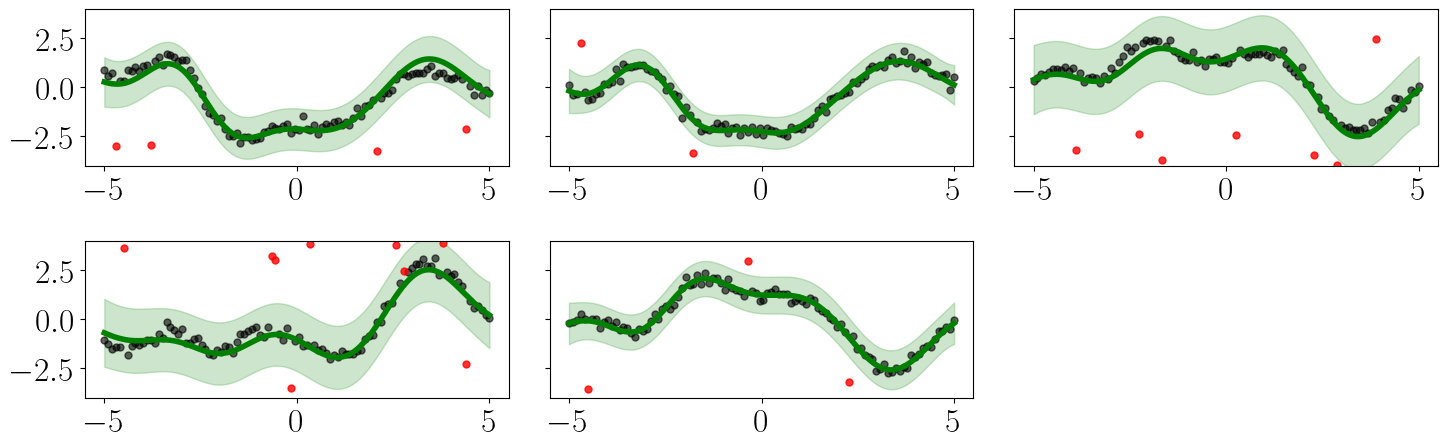

In [6]:
# Plotting
fig, axs = plt.subplots(2, 3, figsize=(15, 5))

for i in range(D):
    ax = axs[i // 3, i % 3]
    # Separate inliers and outliers
    x_all = x_train.flatten()
    y_all = Y_train[:, i]
    is_outlier = outlier_mask[:, i]

    ax.plot(x_all[~is_outlier], y_all[~is_outlier], 'o', color='black', alpha=0.6, label=f'Output {i+1} - inliers')
    ax.plot(x_all[is_outlier], y_all[is_outlier], 'o', color='red', alpha=0.8, label='Outliers')
    ax.plot(x_test.flatten(), mu_morcgp[:, i], '-', color='Green', label=f'Predicted Mean')
    ax.fill_between(x_test.flatten(), mu_morcgp[:, i] - 2*std_morcgp[:, i], mu_morcgp[:, i] + 2*std_morcgp[:, i], color='Green', alpha=0.2, label=f'±2 Std. Dev.')
    ax.set_ylim([-4, 4])
    if i % 3 != 0:
        ax.set_yticklabels([])

# Hide the unused 6th subplot
axs[1, 2].axis('off')

plt.tight_layout()
plt.show()

In [5]:
# morcgp = MORCGPRegressor_NC_fixed_weights(mean = 0, length_scale=optim_length_scale, noise = optim_noise, A=A)
morcgp = MORCGPRegressor_fixed_weights(mean = 0, length_scale=optim_length_scale, noise = optim_noise, A=optim_A)
predictive_mean, predictive_variances = morcgp.fit(x_train, Y_train, B_weighted=optim_B, noise_weighted=optim_noise)

# print(morcgp.loo_cv(length_scale=optim_length_scale, noise=optim_noise, A=A, weighted=False))

# Optimize hyperparameters
morcgp.optimize_loo_cv(weighted=True, print_opt_param = True, print_iter_param=True)

x_test = np.linspace(-5, 5, 200).reshape(-1, 1)
mu_morcgp, var_morcgp = morcgp.predict(x_test)
std_morcgp = np.sqrt(var_morcgp + morcgp.noise)

-339.7327173979521
-339.73271737035367
-339.73271770062127
-339.7327176385719
-339.7327176235458
-339.7327176835071
-339.73271765985766
-339.7327174454001
-339.7327173016367
-339.73271746127796
-339.73271735910976
-339.7327173850552
-339.7327173637002
-339.73271751066414
-339.73271730920595
-339.7327174080162
-339.73271750012003
-339.7327174192005
-339.73271742426834
-339.7327174115386
-339.7327174121312
-339.7327173636259
-339.7327174074543
-339.73271746612073
-339.7327173405243
-339.7327174023258
-339.73271746118184
-339.7327173985413
-339.73271743537487
-339.7327173243358
-339.7327173506644
-339.73271757759096
-309.83858337307913
-309.8385833342346
-309.8385835949229
-309.838583541623
-309.8385835439937
-309.8385833816622
-309.8385835821212
-309.8385835249364
-309.83858247267574
-309.83858313818564
-309.83858355523614
-309.83858271683704
-309.8385830985539
-309.8385849824953
-309.8385838426988
-309.8385829474217
-309.83858473304826
-309.8385834537773
-309.8385827876844
-309.83858321